# Cancer Inhibitors

## About the project

Cancer is a multi gene disease, and the modern medical therapies focus on protein kinase which are play important role the development of cancer.

Each protein kinase regulate each different pathway. These kinase regulate the cell differentiation, cell proliferation.
There are three type of cancer gene:
* Oncogene, where the over representation or over activation of the gene lead to cancer.
* Tumorsuppressor, where the inactivation of the gene lead to cancer.
* Context-dependent, where development of the cancer depend on tissue or other genes.

As cancer is a multi gene disease, several gene malfunction needed to develop the disease.

The new therapies inhibits these kinase to block their functions. In this project we try to predict potential inhibitors.

## About the dataset

The protein kinase list:

* Cyclin-dependent kinase 2: cdk2
* Epidermal growth factor receptor erbB1: egfr_erbB1
* Glycogen synthase kinase-3 beta: gsk3b
* Hepatocyte growth factor receptor: hgfr
* MAP kinase p38 alpha: mapkp38a
* Tyrosine-protein kinase LCK: tpk_lck
* Tyrosine-protein kinase SRC: tpk_src
* Vascular endothelial growth factor receptor 2: vegfr2

For each protein kinase, several thousand inhibitors are collected from chembl database, in which molecules with IC50 lower than 10 uM are usually considered as inhibitors, otherwise non-inhibitors.

### Challenge
Based on those labeled molecules, build your model, and try to make the right prediction.

Additionally, more than 70,000 small molecules are generated from pubchem database. And you can screen these molecules to find out potential inhibitors. P.S. the majority of these molecules are non-inhibitors.

### DataSets(hdf5 version)
There are 8 protein kinase files and 1 pubchem negative samples file.
Taking "cdk2.h5" as an example:

    import h5py
    from scipy import sparse
    hf = h5py.File("../input/cdk2.h5", "r")
    ids = hf["chembl_id"].value # the name of each molecules
    ap = sparse.csr_matrix((hf["ap"]["data"], hf["ap"]["indices"], hf["ap"]["indptr"]), shape=[len(hf["ap"]["indptr"]) - 1, 2039])
    mg = sparse.csr_matrix((hf["mg"]["data"], hf["mg"]["indices"], hf["mg"]["indptr"]), shape=[len(hf["mg"]["indptr"]) - 1, 2039])
    tt = sparse.csr_matrix((hf["tt"]["data"], hf["tt"]["indices"], hf["tt"]["indptr"]), shape=[len(hf["tt"]["indptr"]) - 1, 2039])
    features = sparse.hstack([ap, mg, tt]).toarray() # the samples' features, each row is a sample, and each sample has 3*2039 features
    labels = hf["label"].value # the label of each molecule

### Q&A
Q. What does the "chembl_id" encode for in the PubChem negative samples?
A. Pubchem CID.

Q. Difference between h5 and csv data?
A. The csv format and h5 are different versions. You can use either of them. The h5 version: In my sample code (pkinput.py and pkrandom_forest.py, I use a combination of three sets of fingerprints(ap, mg, and tt for short), and each set contains 2039 fingerprints, the total number of fingerprints(columns) are 6117. The csv version: The first column is the label, the rest columns are feature. Only the set of Mogan(mg for short) fingerprints is used as features, and the number is 8192.

Q. How the features(fingerprints) are generated? How does the features(fingerprints) selected?
A. (Take csv version as an example)The features are a subset of fingerprints. The fingerprints' ID is just a integer(e.g. 10552354, 10552386, 10552674) and meaningless, thus not showed. That's why there are no column names in csv files. The csv file contains label and features. Expect the first column is label, the left columns are the feature data. The feature data is a matrix with shape=(N, 8192), where N is the number of molecules, and 8192 is the number of fingerprints. The fingerprints are selected if it is 'frequent' enough. The 'rare' fingerprints: the fingerprints only appear in <5%(the ratio could be adjusted) of all the molecules in the dataset.

Q. What does 'ap', 'mg', and 'tt' mean in h5 files?
A. 'ap', 'mg', 'tt' are short for 'Atom Pairs', 'Morgan Fingerprints (Circular Fingerprints)', 'Topological Torsions'. They are three different sets of molecular fingerprints calculated by RDKIT. For more information: http://www.rdkit.org/docs/GettingStartedInPython.html#topological-fingerprints

Q. ID of the molecules in csv version?
A. Unfortunately it's missed and could not be recovered. If you need the molecules, you can use the ID from h5 files, and retrieve their structure in SMILES format by chembl_id from ChEMBL database(or in sdf format by pubchem cid from Pubchem database ), and finally, use RDKit to compute any fingerprints needed.

### Reference
* http://onlinelibrary.wiley.com/doi/10.3322/caac.21338/full
* https://www.ebi.ac.uk/chembl/
* https://pubchem.ncbi.nlm.nih.gov/
* http://www.rdkit.org/
* http://www.rdkit.org/docs/GettingStartedInPython.html#morgan-fingerprints-circular-fingerprints

In [2]:
import numpy as np
import pandas as pd
import h5py
from scipy import sparse
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
print("Modules imported!")
print("Collecting Data...")

Modules imported!


In [13]:
from sklearn.linear_model import OrthogonalMatchingPursuit,LogisticRegression,ElasticNetCV,HuberRegressor, Ridge, Lasso,LassoCV,Lars,BayesianRidge,SGDClassifier,RidgeClassifier, LarsCV
from sklearn.svm import SVC
from sklearn.metrics import RocCurveDisplay
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.model_selection import cross_val_predict
from sklearn import linear_model
from sklearn.metrics import r2_score
print("sklearn modules imported")

sklearn modules imported


In [14]:
import matplotlib.pyplot as plt
print("matplotlib modules imported")

matplotlib modules imported


In [ ]:
from sklearn import svm
from sklearn import metrics
from tqdm import tqdm

In [3]:
files = {
    "cdk2": "input/cdk2.h5",
    "egfr": "input/egfr_erbB1.h5",
    "gsk3b": "input/gsk3b.h5",
    "hgfr": "input/hgfr.h5",
    "map_k_p38a": "input/map_k_p38a.h5",
    "tpk_lck": "input/tpk_lck.h5",
    "vegfr2": "input/vegfr2.h5",
}

In [4]:
def pre_process_data(filepath):
    hf = h5py.File(filepath, "r")
    ids = hf["chembl_id"]
    ap = sparse.csr_matrix((hf["ap"]["data"], hf["ap"]["indices"], hf["ap"]["indptr"]), shape=[len(hf["ap"]["indptr"]) - 1, 2039])
    mg = sparse.csr_matrix((hf["mg"]["data"], hf["mg"]["indices"], hf["mg"]["indptr"]), shape=[len(hf["mg"]["indptr"]) - 1, 2039])
    tt = sparse.csr_matrix((hf["tt"]["data"], hf["tt"]["indices"], hf["tt"]["indptr"]), shape=[len(hf["tt"]["indptr"]) - 1, 2039])
    features = sparse.hstack([ap, mg, tt]).toarray() # the samples' features, each row is a sample, and each sample has 3*2039 features
    labels = hf["label"] # the label of each molecule
    return features,labels,ids

In [6]:
features,labels,ids = pre_process_data(files["egfr"])

In [7]:
labels

<HDF5 dataset "label": shape (6937,), type "<i8">

In [8]:
from sklearn.preprocessing import normalize
from scipy.sparse import coo_matrix, csr_matrix

def cosine(plays):
    normalized = normalize(plays)
    return normalized.dot(normalized.T)


def bhattacharya(plays):
    plays.data = np.sqrt(plays.data)
    return cosine(plays)


def ochiai(plays):
    plays = csr_matrix(plays)
    plays.data = np.ones(len(plays.data))
    return cosine(plays)


def bm25_weight(data, K1=1.2, B=0.8):
    """ Weighs each row of the matrix data by BM25 weighting """
    # calculate idf per term (user)
    N = float(data.shape[0])
    idf = np.log(N / (1 + np.bincount(data.col)))

    # calculate length_norm per document (artist)
    row_sums = np.squeeze(np.asarray(data.sum(1)))
    average_length = row_sums.sum() / N
    length_norm = (1.0 - B) + B * row_sums / average_length

    # weight matrix rows by bm25
    ret = coo_matrix(data)
    ret.data = ret.data * (K1 + 1.0) / (K1 * length_norm[ret.row] + ret.data) * idf[ret.col]
    return ret


def bm25(plays):
    plays = bm25_weight(plays)
    return plays.dot(plays.T)

def get_largest(row, N=10):
    if N >= row.nnz:
        best = zip(row.data, row.indices)
    else:
        ind = np.argpartition(row.data, -N)[-N:]
        best = zip(row.data[ind], row.indices[ind])
    return sorted(best, reverse=True)


def calculate_similar_artists(similarity, artists, artistid):
    neighbours = similarity[artistid]
    top = get_largest(neighbours)
    return [(artists[other], score, i) for i, (score, other) in enumerate(top)]



similarity = bm25(coo_matrix(features)).todense()

similarity

matrix([[ 784.73248086,  292.38740423,   75.49049473, ...,   37.16143582,
          147.11303014,   21.69833943],
        [ 292.38740423, 1571.34895607,  376.39003542, ...,  231.368154  ,
          101.69097538,  112.84419121],
        [  75.49049473,  376.39003542, 2006.03870806, ...,  334.90407899,
          102.57463576,   83.89946588],
        ...,
        [  37.16143582,  231.368154  ,  334.90407899, ..., 1734.41618791,
           49.99396042,   33.42075927],
        [ 147.11303014,  101.69097538,  102.57463576, ...,   49.99396042,
         1483.42138965,   48.77737191],
        [  21.69833943,  112.84419121,   83.89946588, ...,   33.42075927,
           48.77737191, 1705.68227744]])

In [9]:
U, sigma, Vt = np.linalg.svd(similarity[:,:200], full_matrices=False)
sigma = np.diag(sigma)
print(U.shape,sigma.shape,Vt.shape)

(6937, 200) (200, 200) (200, 200)


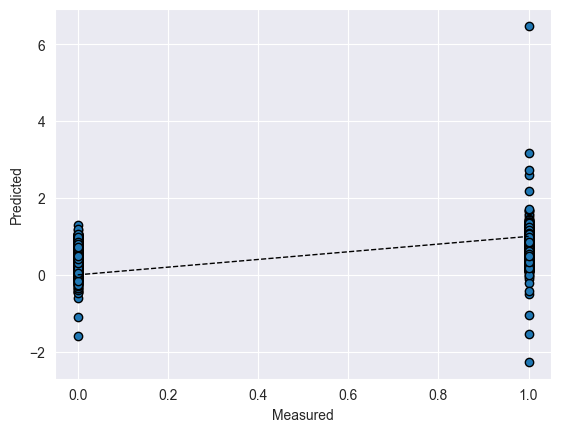

0.23920212016989484


In [11]:
nplabels = labels[:]

lr = linear_model.LinearRegression()
predicted = cross_val_predict(lr, U, nplabels, cv=5)

fig, ax = plt.subplots()
ax.scatter(nplabels, predicted, edgecolors=(0, 0, 0))
ax.plot([nplabels.min(), nplabels.max()], [nplabels.min(), nplabels.max()], 'k--', lw=1)
ax.set_xlabel('Measured')
ax.set_ylabel('Predicted')
plt.show()

print(r2_score(nplabels, predicted))

In [15]:

param_grid = {'C': [0.1,1, 10, 100, 1000], 'gamma': [1,0.1,0.01,0.001,0.0001], 'kernel': ['rbf']}

X = U
def rmsle(y_predicted, y_real):
    return np.sqrt(np.mean(np.power(np.log1p(y_predicted)-np.log1p(y_real), 2)))
def percenterror(y_predicted, y_real):
     return np.round( np.mean(np.abs(y_predicted-y_real) )/ np.mean(y_real) *100 ,1)


Y=labels[:]


names = [
         'ElasticNet',
         'SVC',
         'kSVC',
         'KNN',
         'DecisionTree',
         'RandomForestClassifier',
         'GridSearchCV',
         'HuberRegressor',
         'Ridge',
         'Lasso',
         'LassoCV',
         'Lars',
         'LarsCV',
         'BayesianRidge',
         'SGDClassifier',
         'RidgeClassifier',
         'LogisticRegression',
         'OrthogonalMatchingPursuit',
         ]

classifiers = [
    ElasticNetCV(cv=10, random_state=0),
    SVC(),
    SVC(kernel = 'rbf', random_state = 0),
    KNeighborsClassifier(n_neighbors = 1),
    DecisionTreeClassifier(),
    RandomForestClassifier(n_estimators = 200),
    GridSearchCV(SVC(),param_grid, refit = True, verbose = 1),
    HuberRegressor(fit_intercept=True, alpha=0.0, max_iter=100,epsilon=2.95),
    Ridge(fit_intercept=True, alpha=0.0, random_state=0, normalize=True),
    Lasso(alpha=0.05),
    LassoCV(),
    Lars(n_nonzero_coefs=10),
    LarsCV(),
    BayesianRidge(),
    SGDClassifier(),
    RidgeClassifier(),
    LogisticRegression(),
    OrthogonalMatchingPursuit(),
]
correction= [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0]



def run_predictions(names,classifiers,correction):
    temp=zip(names,classifiers,correction)

    results = {}

    for name, clf,correct in temp:
        regr=clf.fit(X,Y)
        #print( name,'% errors', abs(regr.predict(X)+correct-Y).sum()/(Y.sum())*100)
        y_pred = regr.predict(X)
        print(name,'%error',percenterror(y_pred,Y),'rmsle',rmsle(y_pred,Y))


        # Confusion Matrix
        print(name,'Confusion Matrix')
        matrix = confusion_matrix(Y, np.round(regr.predict(X) ) )
        print( matrix )
        print('--'*40)

        # Classification Report
        print('Classification Report')
        report = classification_report(Y,np.round( regr.predict(X) ) )
        print(report)

        # Accuracy
        print('--'*40)
        logreg_accuracy = round(accuracy_score(Y, np.round( regr.predict(X) ) ) * 100,2)
        print('Accuracy', logreg_accuracy,'%')


        # Save it to results
        results[name] = {
            "report" : report,
            "matrix" : matrix,
            "logreg_accuracy" : logreg_accuracy,
            "y_pred" : y_pred,
        }

    return results


In [16]:
results = run_predictions(names,classifiers,correction)

ElasticNet %error 40.6 rmsle 0.259345615465476
ElasticNet Confusion Matrix
[[   0    0    0]
 [   1  808 1116]
 [   0  232 4780]]
--------------------------------------------------------------------------------
Classification Report
              precision    recall  f1-score   support

        -1.0       0.00      0.00      0.00         0
         0.0       0.78      0.42      0.55      1925
         1.0       0.81      0.95      0.88      5012

    accuracy                           0.81      6937
   macro avg       0.53      0.46      0.47      6937
weighted avg       0.80      0.81      0.78      6937

--------------------------------------------------------------------------------
Accuracy 80.55 %
SVC %error 12.8 rmsle 0.21119447253070386
SVC Confusion Matrix
[[1402  523]
 [ 121 4891]]
--------------------------------------------------------------------------------
Classification Report
              precision    recall  f1-score   support

           0       0.92      0.73      0

In [17]:
def roc_plot_from_res(results):
    fig, ax = plt.subplots(figsize=(10, 10))
    for name, feature in results.items():
        y_pred = feature["y_pred"]
        RocCurveDisplay.from_predictions(Y, y_pred, ax=ax, name='{} auc: {}'.format(name,feature["logreg_accuracy"]))
    ax.plot([0, 1], [0, 1], linestyle="--", lw=2, color="r", alpha=0.8)

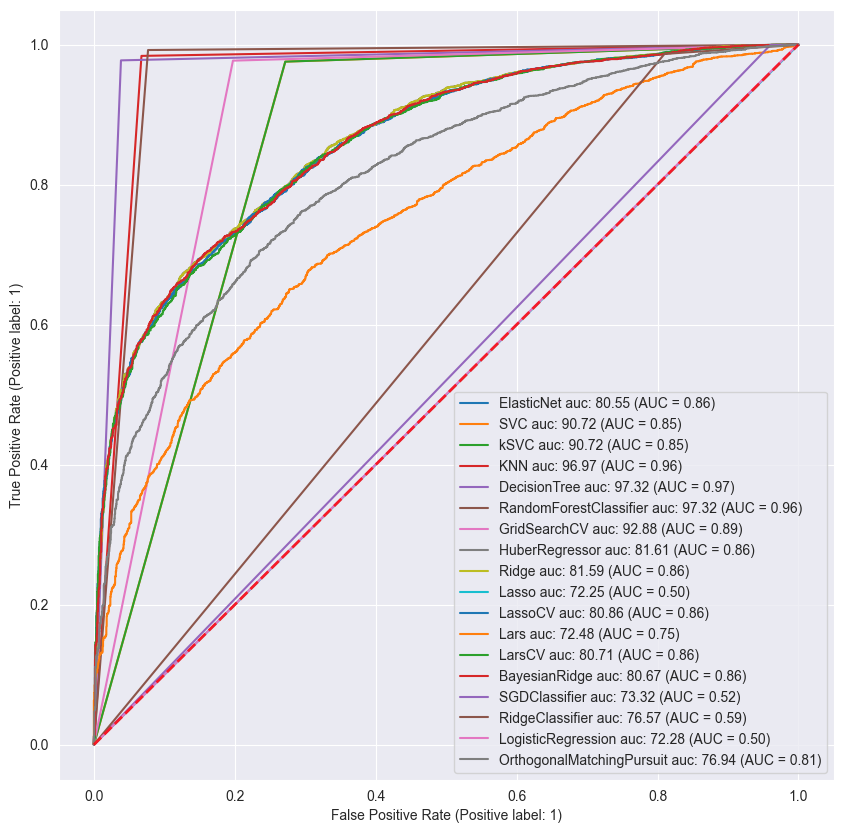

In [18]:
roc_plot_from_res(results)

In [19]:
treshold = 90
below_res = {}
above_res = {}

In [20]:
for name, feature in results.items():
    if feature["logreg_accuracy"] <= treshold:
        below_res[name] = feature
    else:
        above_res[name] = feature

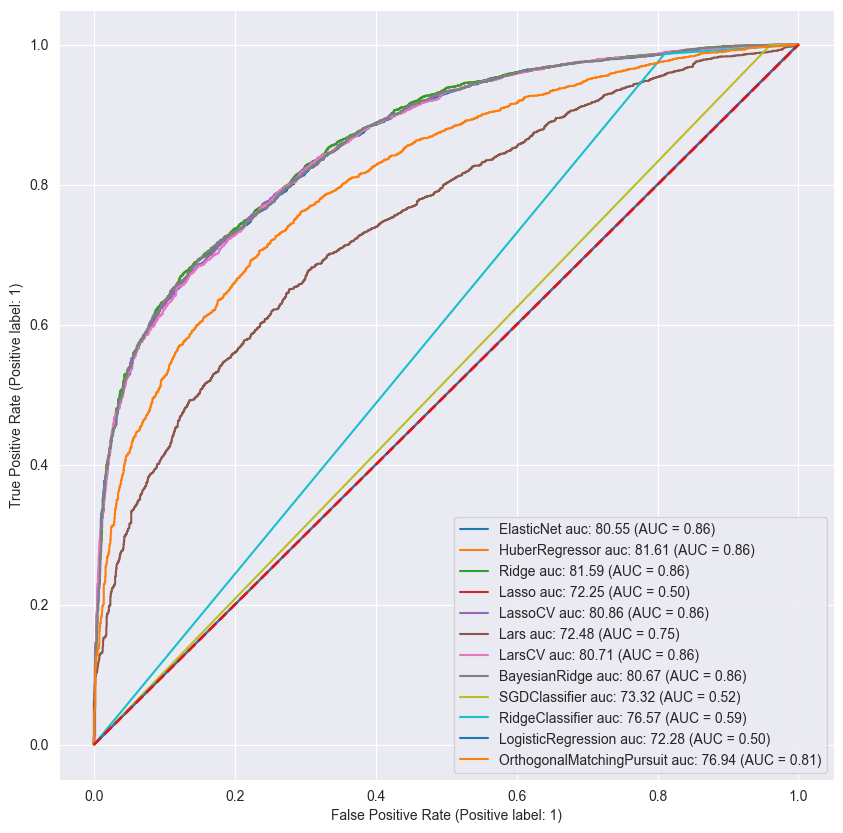

In [21]:
roc_plot_from_res(below_res)

In [22]:
print(below_res.keys())
print(below_res["Lasso"])

dict_keys(['ElasticNet', 'HuberRegressor', 'Ridge', 'Lasso', 'LassoCV', 'Lars', 'LarsCV', 'BayesianRidge', 'SGDClassifier', 'RidgeClassifier', 'LogisticRegression', 'OrthogonalMatchingPursuit'])
{'report': '              precision    recall  f1-score   support\n\n           0       0.00      0.00      0.00      1925\n           1       0.72      1.00      0.84      5012\n\n    accuracy                           0.72      6937\n   macro avg       0.36      0.50      0.42      6937\nweighted avg       0.52      0.72      0.61      6937\n', 'matrix': array([[   0, 1925],
       [   0, 5012]], dtype=int64), 'logreg_accuracy': 72.25, 'y_pred': array([0.72250252, 0.72250252, 0.72250252, ..., 0.72250252, 0.72250252,
       0.72250252])}


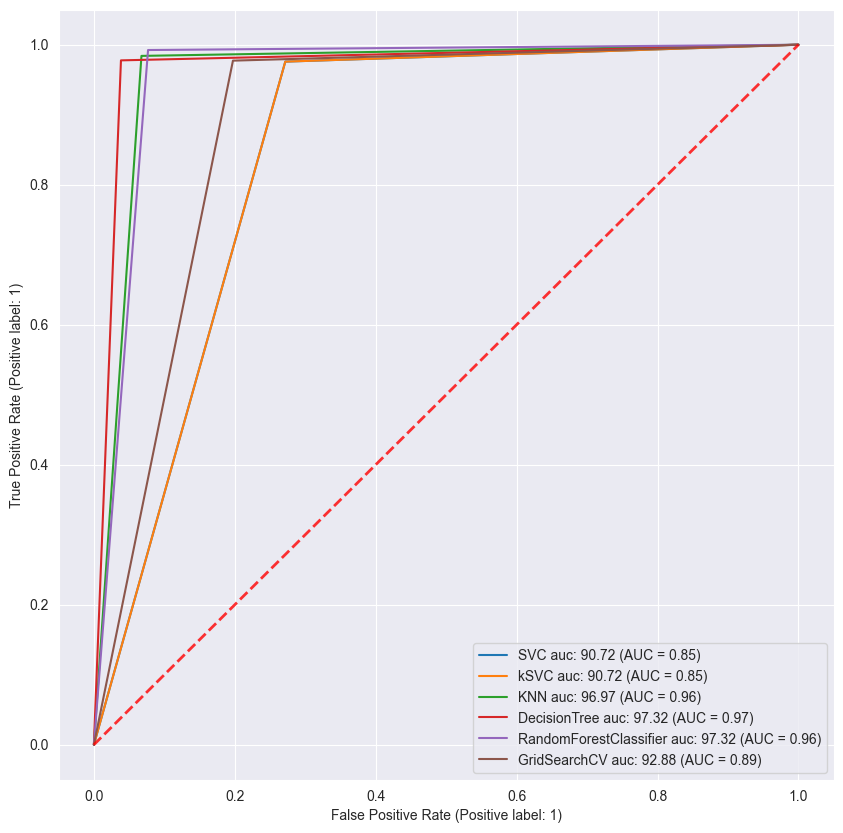

In [23]:
roc_plot_from_res(above_res)

In [24]:
def matrix_plot_from_res(results):
    for name, feature in results.items():
        fig, ax = plt.subplots()
        ax.legend = name
        fig.suptitle("Classifier: " + name)
        sns.heatmap(pd.DataFrame(feature["matrix"]), annot=True, cmap='Reds',ax=ax,fmt='g')
        plt.show()

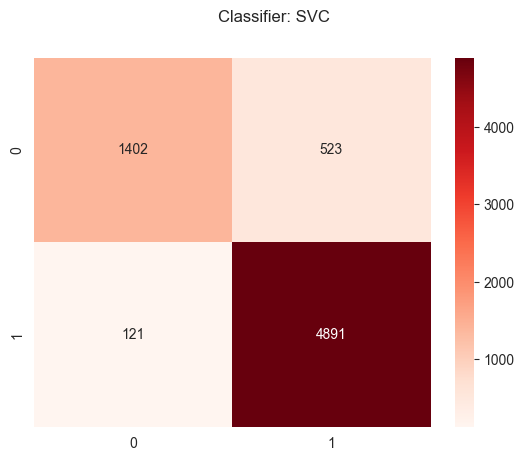

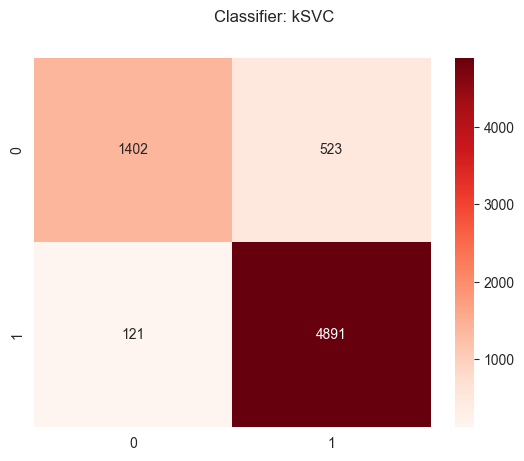

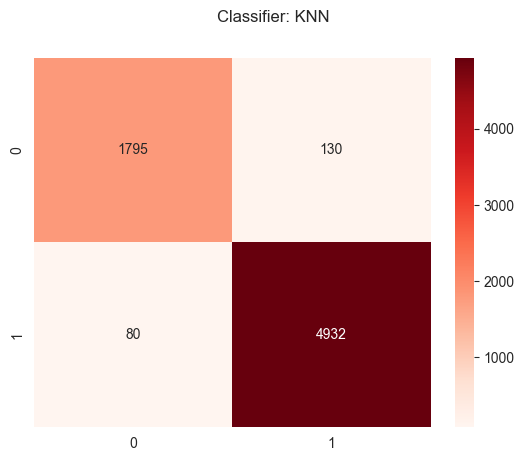

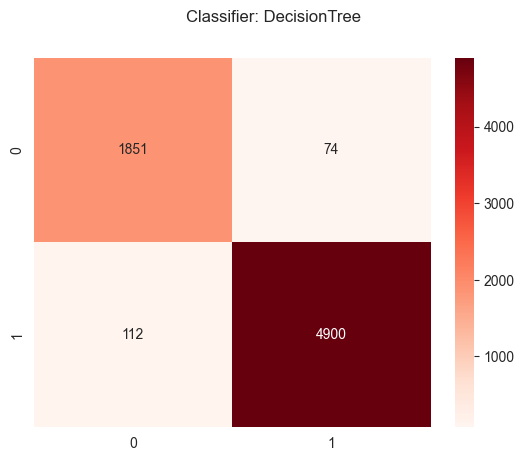

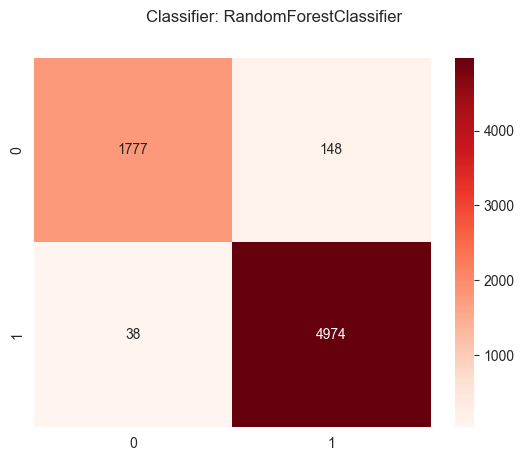

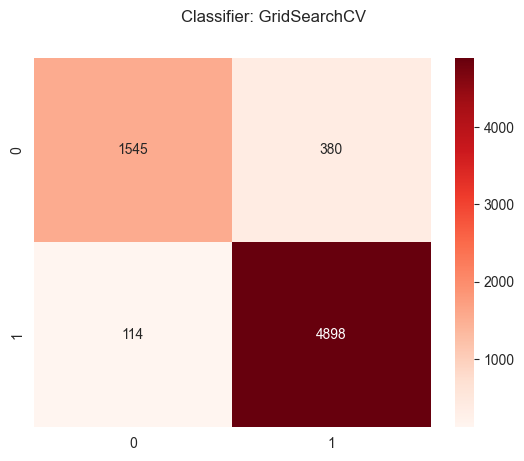

In [25]:
matrix_plot_from_res(above_res)

In [171]:
def SVM_model_predict_tune( x_train, x_test, y_train, y_test, kernel='rbf',
                           gamma='auto', C=1.0, cache_size=200, random_state=None,
                           tol=0.001, coef0=0.0 ):

    clf = svm.SVC( gamma=gamma, C=C, kernel=kernel, probability=True,
                  cache_size=cache_size, random_state=random_state, tol=tol, coef0=coef0 )
    clf.fit( x_train, y_train )

    y_pred = clf.predict_proba( x_test )

    fpr, tpr, thresholds = metrics.roc_curve( y_test, y_pred[:,1] )
    auc = metrics.auc( fpr, tpr )

    return auc

In [172]:

def hyper_parameters_gamma(gammas):
    auc_tune = np.empty( gammas.shape[0], dtype=float )
    for i in tqdm(range(gammas.shape[0])):
        auc_tune[i] = SVM_model_predict_tune( X, X, Y, Y, kernel='rbf', gamma=gammas[i] )
    gamma_best = gammas[ np.argmax( auc_tune, axis=0 ) ]

    fig = plt.figure( figsize=(6,4), dpi=100 )
    plt.title( 'Tuning the hyperparameters of SVM ', fontsize=20)
    plt.plot( gammas, auc_tune, label='AUC' )
    plt.ylabel( 'AUC value', fontsize = 15)
    plt.xlabel( 'Gamma parameter', fontsize = 15)
    plt.xscale( 'log' )
    plt.grid()
    plt.legend()
    plt.show()
    return gamma_best



100%|██████████| 5/5 [00:08<00:00,  1.68s/it]


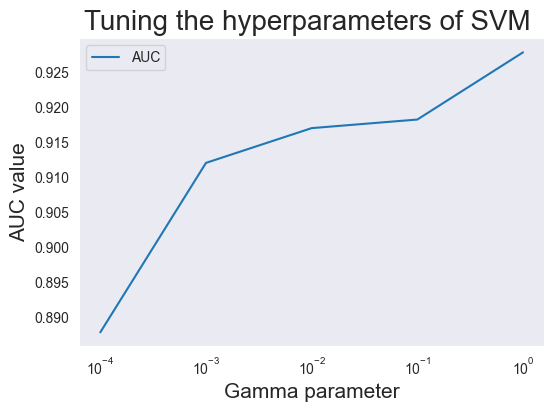

best gamma:  1.0


In [173]:
best_gamma = hyper_parameters_gamma(np.array(param_grid["gamma"]))
print("best gamma: ", best_gamma)

In [174]:
from sklearn.model_selection import RepeatedKFold,RepeatedStratifiedKFold

cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)
lasso_alphas = np.linspace(0, 0.001, 100)
lasso = LassoCV(alphas=lasso_alphas, cv=cv, n_jobs=-1)
lasso.fit(X, Y)
print('alpha: %.2f' % lasso.alpha_)

alpha: 0.00


In [175]:
lasso_alphas

array([0.00000000e+00, 1.01010101e-05, 2.02020202e-05, 3.03030303e-05,
       4.04040404e-05, 5.05050505e-05, 6.06060606e-05, 7.07070707e-05,
       8.08080808e-05, 9.09090909e-05, 1.01010101e-04, 1.11111111e-04,
       1.21212121e-04, 1.31313131e-04, 1.41414141e-04, 1.51515152e-04,
       1.61616162e-04, 1.71717172e-04, 1.81818182e-04, 1.91919192e-04,
       2.02020202e-04, 2.12121212e-04, 2.22222222e-04, 2.32323232e-04,
       2.42424242e-04, 2.52525253e-04, 2.62626263e-04, 2.72727273e-04,
       2.82828283e-04, 2.92929293e-04, 3.03030303e-04, 3.13131313e-04,
       3.23232323e-04, 3.33333333e-04, 3.43434343e-04, 3.53535354e-04,
       3.63636364e-04, 3.73737374e-04, 3.83838384e-04, 3.93939394e-04,
       4.04040404e-04, 4.14141414e-04, 4.24242424e-04, 4.34343434e-04,
       4.44444444e-04, 4.54545455e-04, 4.64646465e-04, 4.74747475e-04,
       4.84848485e-04, 4.94949495e-04, 5.05050505e-04, 5.15151515e-04,
       5.25252525e-04, 5.35353535e-04, 5.45454545e-04, 5.55555556e-04,
      

In [176]:
# lasso = Lasso(0)
# lasso.fit(X, Y)
names = ["lasso","lasso_cv"]
classifiers = [Lasso(0.00001),Lasso(lasso.alpha_)]
correction = [0,0]

In [177]:
lasso_res = run_predictions(names,classifiers,correction)

lasso %error 35.7 rmsle 0.22331468164875198
lasso Confusion Matrix
[[ 462  157    0]
 [  83 1187    1]
 [   0    0    0]]
--------------------------------------------------------------------------------
Classification Report
              precision    recall  f1-score   support

         0.0       0.85      0.75      0.79       619
         1.0       0.88      0.93      0.91      1271
         2.0       0.00      0.00      0.00         0

    accuracy                           0.87      1890
   macro avg       0.58      0.56      0.57      1890
weighted avg       0.87      0.87      0.87      1890

--------------------------------------------------------------------------------
Accuracy 87.25 %
lasso_cv %error 37.9 rmsle 0.23054722555064408
lasso_cv Confusion Matrix
[[ 411  208    0]
 [  64 1206    1]
 [   0    0    0]]
--------------------------------------------------------------------------------
Classification Report
              precision    recall  f1-score   support

         0

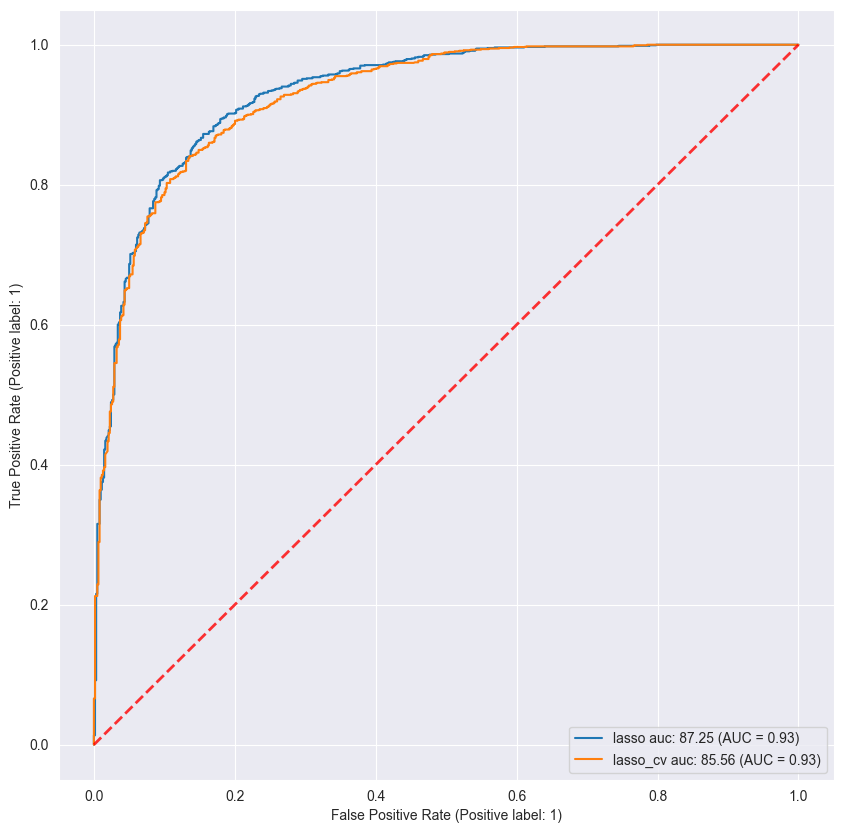

In [178]:
roc_plot_from_res(lasso_res)

In [225]:
def grid_search_optimizer(grid_search,X,Y):
    grid_result = grid_search.fit(X, Y)
    # summarize results
    print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
    means = grid_result.cv_results_['mean_test_score']
    stds = grid_result.cv_results_['std_test_score']
    params = grid_result.cv_results_['params']
    for mean, stdev, param in zip(means, stds, params):
        print("%f (%f) with: %r" % (mean, stdev, param))
    return grid_result.best_params_

In [226]:
def hyper_parameters_logistic_regression(X,Y):
    model = LogisticRegression()
    solvers = ['newton-cg', 'lbfgs', 'liblinear']
    penalty = ['l2']
    c_values = [100, 10, 1.0, 0.1, 0.01]
    # define grid search
    grid = dict(solver=solvers,penalty=penalty,C=c_values)
    cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
    grid_search = GridSearchCV(estimator=model, param_grid=grid, n_jobs=-1, cv=cv, scoring='accuracy',error_score=0)

    best_params = grid_search_optimizer(grid_search,X,Y)

    log_model = LogisticRegression(C=best_params["C"],penalty=best_params["penalty"],
                           solver=best_params["solver"])

    return logistic_params, log_model

In [227]:
logistic_params, log_model = hyper_parameters_logistic_regression(X,Y)

Best: 0.832628 using {'C': 100, 'penalty': 'l2', 'solver': 'newton-cg'}
0.832628 (0.028541) with: {'C': 100, 'penalty': 'l2', 'solver': 'newton-cg'}
0.832628 (0.028541) with: {'C': 100, 'penalty': 'l2', 'solver': 'lbfgs'}
0.832628 (0.028541) with: {'C': 100, 'penalty': 'l2', 'solver': 'liblinear'}
0.821869 (0.024979) with: {'C': 10, 'penalty': 'l2', 'solver': 'newton-cg'}
0.822046 (0.024910) with: {'C': 10, 'penalty': 'l2', 'solver': 'lbfgs'}
0.822046 (0.024910) with: {'C': 10, 'penalty': 'l2', 'solver': 'liblinear'}
0.673016 (0.002116) with: {'C': 1.0, 'penalty': 'l2', 'solver': 'newton-cg'}
0.673016 (0.002116) with: {'C': 1.0, 'penalty': 'l2', 'solver': 'lbfgs'}
0.673016 (0.002116) with: {'C': 1.0, 'penalty': 'l2', 'solver': 'liblinear'}
0.672487 (0.001587) with: {'C': 0.1, 'penalty': 'l2', 'solver': 'newton-cg'}
0.672487 (0.001587) with: {'C': 0.1, 'penalty': 'l2', 'solver': 'lbfgs'}
0.672487 (0.001587) with: {'C': 0.1, 'penalty': 'l2', 'solver': 'liblinear'}
0.672487 (0.001587) wit

In [278]:
names = ["logmodel","hyper_tuned_log_model"]
classifiers = [LogisticRegression(),log_model]
correction = [0,0]

In [279]:
log_res = run_predictions(names,classifiers,correction)

logmodel %error 47.5 rmsle 0.3918438440230072
logmodel Confusion Matrix
[[  15  604]
 [   0 1271]]
--------------------------------------------------------------------------------
Classification Report
              precision    recall  f1-score   support

           0       1.00      0.02      0.05       619
           1       0.68      1.00      0.81      1271

    accuracy                           0.68      1890
   macro avg       0.84      0.51      0.43      1890
weighted avg       0.78      0.68      0.56      1890

--------------------------------------------------------------------------------
Accuracy 68.04 %
hyper_tuned_log_model %error 19.0 rmsle 0.2475158873146681
hyper_tuned_log_model Confusion Matrix
[[ 451  168]
 [  73 1198]]
--------------------------------------------------------------------------------
Classification Report
              precision    recall  f1-score   support

           0       0.86      0.73      0.79       619
           1       0.88      0.94   

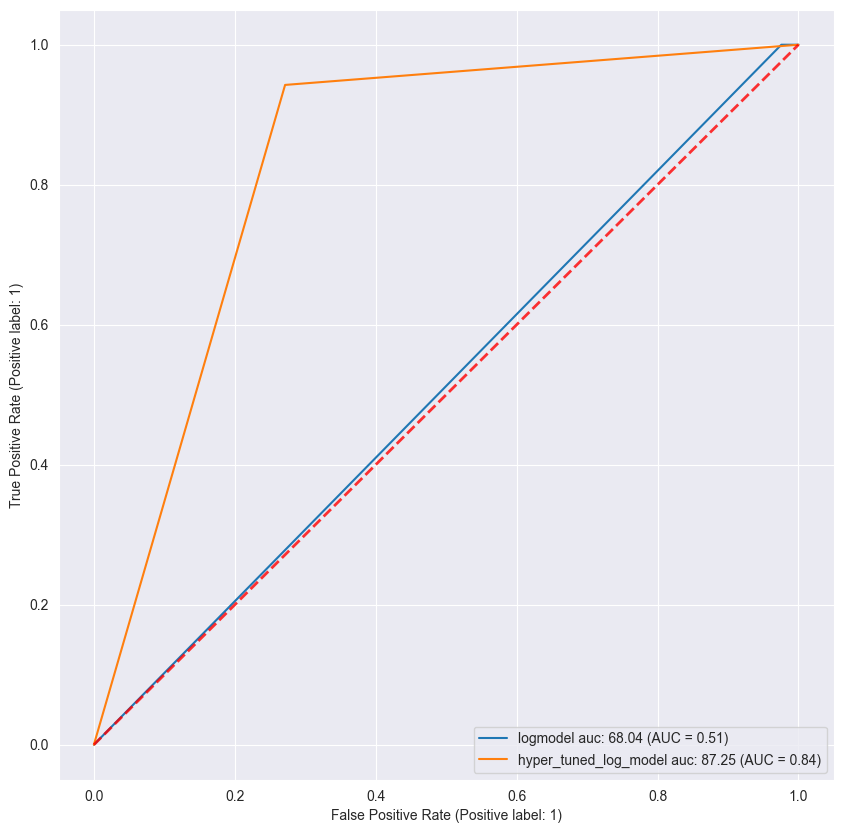

In [280]:
roc_plot_from_res(log_res)

In [231]:
def ridge_classifier_hyper(X,Y):
    # define models and parameters
    model = RidgeClassifier()
    alpha = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
    # define grid search
    grid = dict(alpha=alpha)
    cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
    grid_search = GridSearchCV(estimator=model, param_grid=grid, n_jobs=-1, cv=cv, scoring='accuracy',error_score=0)

    best_params = grid_search_optimizer(grid_search,X,Y)

    ridge_model = RidgeClassifier(best_params["alpha"])

    return ridge_model, best_params["alpha"]

In [232]:
ridge_model, alpha = ridge_classifier_hyper(X,Y)

Best: 0.833510 using {'alpha': 0.1}
0.833510 (0.024275) with: {'alpha': 0.1}
0.831922 (0.026620) with: {'alpha': 0.2}
0.828395 (0.025363) with: {'alpha': 0.3}
0.824339 (0.027336) with: {'alpha': 0.4}
0.818166 (0.025685) with: {'alpha': 0.5}
0.818519 (0.025673) with: {'alpha': 0.6}
0.814109 (0.024580) with: {'alpha': 0.7}
0.811993 (0.025143) with: {'alpha': 0.8}
0.809347 (0.024798) with: {'alpha': 0.9}
0.806702 (0.024351) with: {'alpha': 1.0}


ridge_model %error 25.6 rmsle 0.2878746076024993
ridge_model Confusion Matrix
[[ 310  309]
 [  17 1254]]
--------------------------------------------------------------------------------
Classification Report
              precision    recall  f1-score   support

           0       0.95      0.50      0.66       619
           1       0.80      0.99      0.88      1271

    accuracy                           0.83      1890
   macro avg       0.88      0.74      0.77      1890
weighted avg       0.85      0.83      0.81      1890

--------------------------------------------------------------------------------
Accuracy 82.75 %
hyper_tuned_ridge_model %error 19.7 rmsle 0.2520951922746962
hyper_tuned_ridge_model Confusion Matrix
[[ 429  190]
 [  60 1211]]
--------------------------------------------------------------------------------
Classification Report
              precision    recall  f1-score   support

           0       0.88      0.69      0.77       619
           1       0.86   

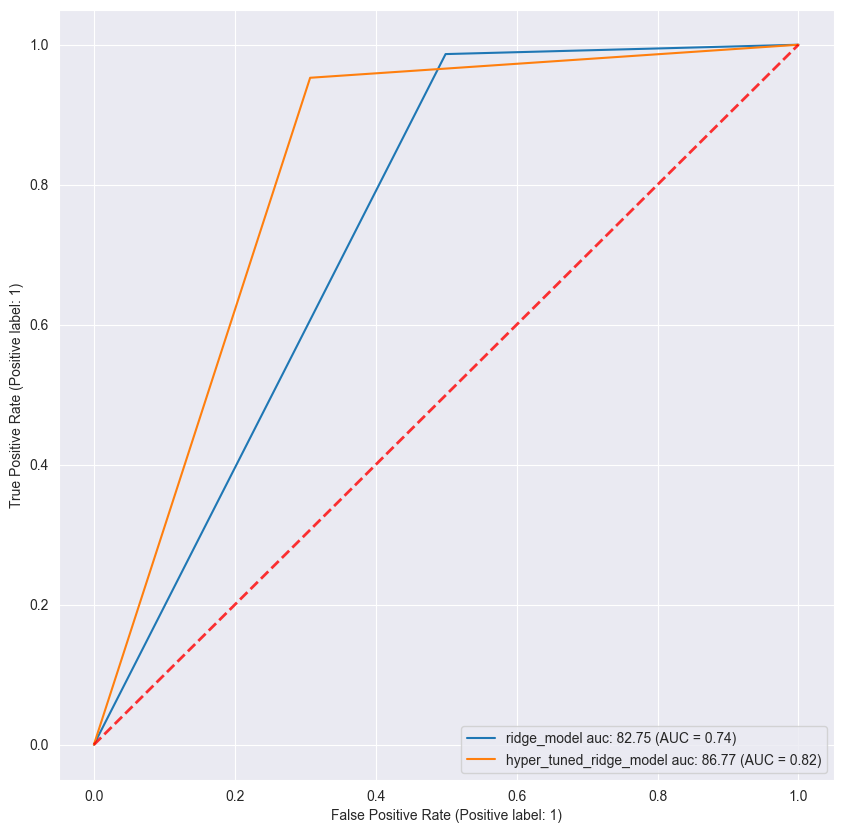

In [233]:
names = ["ridge_model", "hyper_tuned_ridge_model"]
classifiers = [RidgeClassifier(), ridge_model]
correction = [0, 0]
ridge_res = run_predictions(names, classifiers, correction)
roc_plot_from_res(ridge_res)

In [274]:

def sgd_classifier_hyper(X,Y):

    model = SGDClassifier()
    # define models and parameters
    grid = {
    # 'alpha': [1e-8,1e-7,1e-6,1e-5,1e-4,1e-3,1e-2,1e-1], # learning rate
    'alpha': np.linspace(1e-06,1e-04,10), # learning rate
    # 'n_iter': [1000], # number of epochs
    'loss': ['log_loss','hinge','squared_hinge','log'], # logistic regression,
    'penalty': ['l1','l2', 'elasticnet'],
    'n_jobs': [-1]
    }
    # paramGrid = ParameterGrid(grid)

    cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
    grid_search = GridSearchCV(estimator=model, param_grid=grid, cv=cv, scoring='accuracy',error_score=0)

    best_params = grid_search_optimizer(grid_search,X,Y)

    sgd_model = SGDClassifier(alpha=best_params["alpha"],n_jobs=best_params["n_jobs"],
                              loss=best_params["loss"],penalty=best_params["penalty"])

    return sgd_model, best_params

In [275]:
sgd_model, sgd_best = sgd_classifier_hyper(X,Y)

Best: 0.836332 using {'alpha': 8.900000000000001e-05, 'loss': 'hinge', 'n_jobs': -1, 'penalty': 'l1'}
0.788183 (0.062611) with: {'alpha': 1e-06, 'loss': 'log_loss', 'n_jobs': -1, 'penalty': 'l1'}
0.776190 (0.083949) with: {'alpha': 1e-06, 'loss': 'log_loss', 'n_jobs': -1, 'penalty': 'l2'}
0.800353 (0.050950) with: {'alpha': 1e-06, 'loss': 'log_loss', 'n_jobs': -1, 'penalty': 'elasticnet'}
0.821164 (0.030005) with: {'alpha': 1e-06, 'loss': 'hinge', 'n_jobs': -1, 'penalty': 'l1'}
0.798765 (0.067447) with: {'alpha': 1e-06, 'loss': 'hinge', 'n_jobs': -1, 'penalty': 'l2'}
0.790300 (0.062327) with: {'alpha': 1e-06, 'loss': 'hinge', 'n_jobs': -1, 'penalty': 'elasticnet'}
0.792063 (0.053317) with: {'alpha': 1e-06, 'loss': 'squared_hinge', 'n_jobs': -1, 'penalty': 'l1'}
0.775309 (0.066278) with: {'alpha': 1e-06, 'loss': 'squared_hinge', 'n_jobs': -1, 'penalty': 'l2'}
0.790300 (0.055551) with: {'alpha': 1e-06, 'loss': 'squared_hinge', 'n_jobs': -1, 'penalty': 'elasticnet'}
0.804762 (0.050516) wi

sgd_model %error 20.1 rmsle 0.2551023983251597
sgd_model Confusion Matrix
[[ 421  198]
 [  58 1213]]
--------------------------------------------------------------------------------
Classification Report
              precision    recall  f1-score   support

           0       0.88      0.68      0.77       619
           1       0.86      0.95      0.90      1271

    accuracy                           0.86      1890
   macro avg       0.87      0.82      0.84      1890
weighted avg       0.87      0.86      0.86      1890

--------------------------------------------------------------------------------
Accuracy 86.46 %
hyper_tuned_sgd_model %error 18.7 rmsle 0.24597050766616568
hyper_tuned_sgd_model Confusion Matrix
[[ 445  174]
 [  64 1207]]
--------------------------------------------------------------------------------
Classification Report
              precision    recall  f1-score   support

           0       0.87      0.72      0.79       619
           1       0.87      0.95

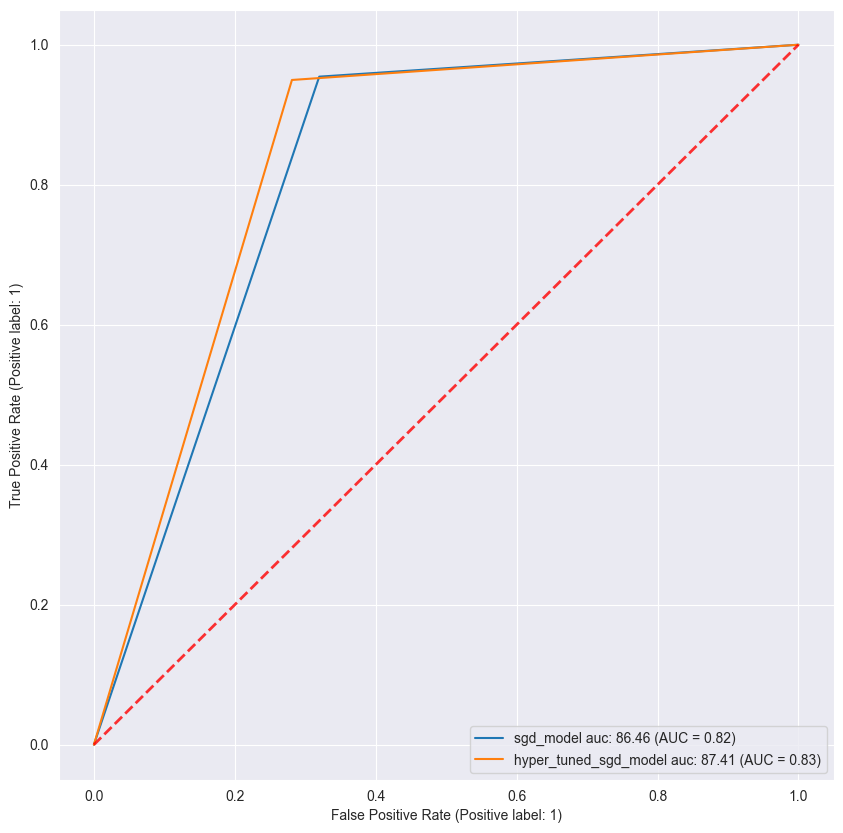

In [276]:
names = ["sgd_model", "hyper_tuned_sgd_model"]
classifiers = [SGDClassifier(), sgd_model]
correction = [0, 0]
sgd_res = run_predictions(names, classifiers, correction)
roc_plot_from_res(sgd_res)